# Height and Weight of top riders in the Tour de France

### How big is too big? The leaner the better?

The idea of this visualization is to see if there is a predomintant body-type among the riders reaching the podium of the biggest cycling event of the year, the Tour de France.    
  

  
**For a bit of context**  

The Tour is the most important cycling race in the world, and it consists on 21 stage across differente terrains (flat, hilly, mountain) and different type of stages (time trials, mountain top finishes). The general classification is computed by adding the time of each stage for each rider. Time differences between riders usually occur in mountain stages and time trials 
In general, taller and heavier riders are more powerful when rolling in flat, which gives them advantage in time trials, especially over long courses (>30km). On the other hand, climbers are usually shorter and lighter, allowing them to go uphill faster than their heavier competitors when crossing the Alps and Pyrenees.    
  
  
  
**So what is the ideal body type?**

Is it better to be a short and skinny climber? or a big guy rolling full gas on time trials? or somewhere inbetween?
The expected answer is: *there is no recipe for success*  
After all, the course, the type of dominant riders, the strategies, the equipement... everything has changed through the years.  
But I'll make this visualization anyway. Just for fun.

### Load the packages

In [1]:
library(rvest) #for data scrapping
library(tidyverse) #for data management and visualization
library(gganimate) #to add the final(interactive) plot twist

Warning message:
"package 'rvest' was built under R version 3.5.3"
Loading required package: xml2

Warning message:
"package 'xml2' was built under R version 3.5.3"
Warning message:
"package 'tidyverse' was built under R version 3.5.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Warning message:
"package 'tibble' was built under R version 3.5.3"
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Warning message:
"package 'readr' was built under R version 3.5.3"
Warning message:
"package 'purrr' was built under R version 3.5.3"
Warning message:
"package 'dplyr' was built under R version 3.5.3"
Warning message:
"package 'stringr' was built under R version 3.5.3"
Warning message:
"package 'forcats' was built under R version 3

### Get the historic podium data

Data is collected from the [results page](https://www.procyclingstats.com/race/tour-de-france/2020/gc/history) of the Tour de France in Pro Cycling Stats.  

This will be the guide to collect data from each rider later.

In [3]:
# Get the data from the web, process the html into text and then a DataFrame

tour <- "https://www.procyclingstats.com/race/tour-de-france/2020/gc/history"
tour_html <- read_html(tour)
tour_data <- html_text(html_nodes(tour_html, 'td')) %>% strsplit("\t") #from html to text
tour_df <- unlist(tour_data[-(1:4)]) %>%
            matrix(ncol=4, byrow=TRUE) %>%            #from text to a data frame
            data.frame()
colnames(tour_df) <- c("year", "1st", "2nd", "3rd")
head(tour_df, 15) # Check the results for the past 15 years as sample

year,1st,2nd,3rd
<fct>,<fct>,<fct>,<fct>
2019,Bernal Egan,Thomas Geraint,Kruijswijk Steven
2018,Thomas Geraint,Dumoulin Tom,Froome Chris
2017,Froome Chris,Urán Rigoberto,Bardet Romain
2016,Froome Chris,Bardet Romain,Quintana Nairo
2015,Froome Chris,Quintana Nairo,Valverde Alejandro
2014,Nibali Vincenzo,Peraud Jean-Christophe,Pinot Thibaut
2013,Froome Chris,Quintana Nairo,Rodríguez Joaquim
2012,Wiggins Bradley,Froome Chris,Nibali Vincenzo
2011,Evans Cadel,Schleck Andy,Schleck Fränk


Now, I need to convert it from wide DataFrame to long DataFrame, with proper column names and everything in lower case for the future

In [9]:
tour_df_long <- pivot_longer(tour_df, -year)
colnames(tour_df_long) <- c("year", "position", "rider")
tour_df_long$rider <- tolower(tour_df_long$rider)

head(tour_df_long, 12)

year,position,rider
<fct>,<chr>,<chr>
2019,1st,bernal egan
2019,2nd,thomas geraint
2019,3rd,kruijswijk steven
2018,1st,thomas geraint
2018,2nd,dumoulin tom
2018,3rd,froome chris
2017,1st,froome chris
2017,2nd,urán rigoberto
2017,3rd,bardet romain


Unfortunately, cleaning the data in this case involves dealing with one of the worst parts of the cycling world: the doping.  


Here, dirty riders (marked with \*) are dirty data, and will be removed from the classification. When possible, they will be replaced by the rider that was officially given their spot in the podium (originally between square brackets).

In [10]:
for(i in 1:nrow(tour_df_long)){
  if(str_detect(tour_df_long[i,3],"\\[")){
    
    tour_df_long[i,3] <- sub(".*\\[([^][]+)].*", "\\1", tour_df_long[i,3])
  }
}

And now, some extra cleaning of the text info (special characters, peculiarities of some names...)

In [11]:
tour_df_long$rider <- tour_df_long$rider %>%
  str_trim() %>% # Trim leading / trailing spaces
  sub("á", "a", .) %>%
  sub("ä", "a", .) %>%
  sub("é", "e", .) %>%
  sub("í", "i", .) %>%
  sub("ï", "i", .) %>%
  sub("ó", "o", .) %>%
  sub("ö", "o", .) %>%
  sub("ü", "u", .) %>%
  sub("ñ", "n", .) %>%
  sub("van ", "van-",.) %>%
  sub("-den ", "-den-",.) %>%
  sub("-der ", "-der-",.) %>%
  sub("de waele", "de-waele",.)  #a bit of hard coding here...

Finally, we need to change from "surname name" to "name-surname" format.

In [13]:
tour_df_long$rider <- paste0(str_split_fixed(tour_df_long$rider, " ", 2)[,2], "-", str_split_fixed(tour_df_long$rider, " ", 2)[,1])

head(tour_df_long,6)

year,position,rider
<fct>,<chr>,<chr>
2019,1st,egan-bernal
2019,2nd,geraint-thomas
2019,3rd,steven-kruijswijk
2018,1st,geraint-thomas
2018,2nd,tom-dumoulin
2018,3rd,chris-froome


Doping, second part. You always have to keep cleaning it.  
Now, it is time to eliminate those riders that were disqualified but nobody took its place.  
For example, this is the case of the dude who won it 7 times in a row while participating on a large and complex doping network.  
Yeah, you know who it is. Let's not give him more press.

In [14]:
tour_df_long$rider[str_detect(tour_df_long$rider, "\\*")] <- NA

And some more name cleaning, after finding that some peculiarities in the URL of their profiles in the web.  

This is also a bit hard-coded, but whatever...

In [15]:
tour_df_long$rider <- tour_df_long$rider %>%
  sub("chris-froome", "christopher-froome",.) %>%
  sub("zulle", "zulle2",.) %>%
  sub("lopez", "lopez-carril",.) %>%
  sub("stopel", "stoepel",.) %>%
  sub("defraye", "defraye-1",.) %>%
  sub(" ", "-",.)

### Now, get the rider's data
Also from Pro Cycling Stats, we want date of birth, height and weight.  

First, DataFrame with every rider and empty of information

In [16]:
all_riders_data <- data.frame("rider" = (unique(tour_df_long$rider[!is.na(tour_df_long$rider)])),
                         "birth" = NA,
                         "weight" = NA,
                         "height" = NA)
head(all_riders_data, 10)

rider,birth,weight,height
<fct>,<lgl>,<lgl>,<lgl>
egan-bernal,NA,NA,NA
geraint-thomas,NA,NA,NA
steven-kruijswijk,NA,NA,NA
tom-dumoulin,NA,NA,NA
christopher-froome,NA,NA,NA
rigoberto-uran,NA,NA,NA
romain-bardet,NA,NA,NA
nairo-quintana,NA,NA,NA
alejandro-valverde,NA,NA,NA


Using their name in the table, I can make the URL of their profiles and retrieve the information from there and straight into the table.

Height and weight are not always available.

In [19]:
for(i in 1:nrow(all_riders_data)){
  #message(paste0("Rider ", i)) #This is only to know the progress
    
  pcs_rider_url <- paste0("https://www.procyclingstats.com/rider/", all_riders_data[i,1])
    
  rider_data <- read_html(pcs_rider_url) %>%
    html_nodes('.rdr-info-cont') %>%
    html_text() %>%
    unlist() %>%
    strsplit(.,"Date of birth: |Nationality: |Weight: |Height: | m")
  
  all_riders_data[i,'birth'] <- rider_data[[1]][2] #Fill the fields in the DataFrame
  all_riders_data[i,'weight'] <- rider_data[[1]][4]
  all_riders_data[i,'height'] <- rider_data[[1]][5]
  
}

In [20]:
# A bit of extra cleaning and format changes
riders_data_clean <- all_riders_data[str_detect(all_riders_data$weight, "kg"), ] %>% na.omit() #Remove those without weight and height data
riders_data_clean$weight <- riders_data_clean$weight %>% str_trim() %>% sub(" kg", "", .) %>% as.integer()
riders_data_clean$height <- riders_data_clean$height %>% as.numeric()

head(riders_data_clean, 20)

rider,birth,weight,height
<fct>,<chr>,<int>,<dbl>
egan-bernal,13th January 1997 (23),60,1.75
geraint-thomas,25th May 1986 (33),71,1.83
steven-kruijswijk,7th June 1987 (32),63,1.78
tom-dumoulin,11th November 1990 (29),69,1.85
christopher-froome,20th May 1985 (34),66,1.86
rigoberto-uran,26th January 1987 (33),63,1.73
romain-bardet,9th November 1990 (29),65,1.84
nairo-quintana,4th February 1990 (30),59,1.67
alejandro-valverde,25th April 1980 (40),61,1.77


### Finally, combine both tables and plot it

In [23]:
# Left join on the results DataFrame (tour_df_long)
# This means taking the results DF as reference and add the matching information from riders' DF into it
tour_final <- left_join(tour_df_long, riders_data_clean)
tour_final$year <- tour_final$year %>% as.character() %>% as.numeric()

head(tour_final, 18)

Joining, by = "rider"

Warning message:
"Column `rider` joining character vector and factor, coercing into character vector"


year,position,rider,birth,weight,height
<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>
2019,1st,egan-bernal,13th January 1997 (23),60,1.75
2019,2nd,geraint-thomas,25th May 1986 (33),71,1.83
2019,3rd,steven-kruijswijk,7th June 1987 (32),63,1.78
2018,1st,geraint-thomas,25th May 1986 (33),71,1.83
2018,2nd,tom-dumoulin,11th November 1990 (29),69,1.85
2018,3rd,christopher-froome,20th May 1985 (34),66,1.86
2017,1st,christopher-froome,20th May 1985 (34),66,1.86
2017,2nd,rigoberto-uran,26th January 1987 (33),63,1.73
2017,3rd,romain-bardet,9th November 1990 (29),65,1.84


And now, time to plot it!

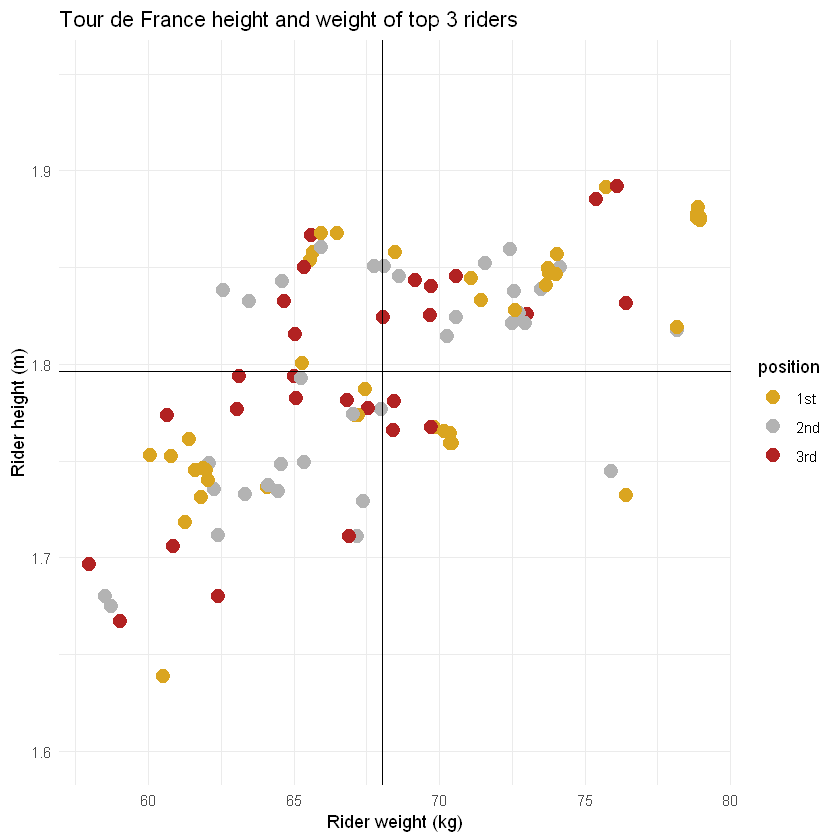

In [24]:
tour_final %>% na.omit() %>%
  ggplot(aes(x=weight, y=height, color=position))+
    geom_point(size=3.5, position = position_jitter(width = 0.5, height = 0.01))+ #A bit of jitter to avoid full overlap between points
    scale_color_manual(values=c("1st" = "goldenrod", "2nd"="gray70","3rd"="firebrick"))+
    geom_hline(yintercept = mean(na.omit(tour_final$height)))+
    geom_vline(xintercept = mean(na.omit(tour_final$weight)))+
    ylim(1.60, 1.95)+
    theme_minimal()+
    labs(x = "Rider weight (kg)", y="Rider height (m)", title = "Tour de France height and weight of top 3 riders")
 

And the code for the animated version

In [27]:
tour_final %>% na.omit() %>%
  ggplot(aes(x=weight, y=height, color=position))+
    geom_point(size=3.5, position = position_jitter(width = 0.5, height = 0.005))+
    scale_color_manual(values=c("1st" = "goldenrod", "2nd"="gray70","3rd"="firebrick"))+
    geom_hline(yintercept = mean(na.omit(tour_final$height)))+
    geom_vline(xintercept = mean(na.omit(tour_final$weight)))+
    ylim(1.60, 1.95)+
    theme_minimal()+
    transition_states(year, transition_length = 3, state_length = 3)+
    labs(x = "Rider weight (kg)", y="Rider height (m)", title = "Tour de France height and weight of top 3 riders. Year: {closest_state}")+
    shadow_mark() -> p

podium_animation <- animate(p)
anim_save("tour_data.gif", podium_animation)

## Final comments:

- As expected, there isn't a especific body size that leads to success. Different eras were dominated by different types of riders  
- Rider's data is based on their documented data on Pro Cycling Stats, but does not reflect changes over time (for example if a rider gained or lost weight form one year to another). Also, variation between very close point is ficticious, created randomly by the jitter effect to help visualize overlapping points. This is clear in the Indurain data (top-righ golden points), where it seems from the plot like he changed his height between years.  
- Changes over time in the body type can imply differences in the course, favouring different types of riders. But it might as well be an artifact of the dominant riders of each time(like Anquetil, Hinault, Merckx, Indurain,...).


At the end of the day, this was made just for fun, good practice and love for cycling.  
Have a good ride.